# Seminar 3 and Homework 2

In lectures 3 and 4 you have examined the basics of speech recognition and covered the Connectionist Temporal Classification (CTC) model in detail. You are now ready to train your first "adult" speech recognition system!

In this joint seminar and homework exercise you will explore speech recongition using Connectionist Temporal Classification (CTC). This seminar and homework are both LARGE and CHALLENGE, so expect to spent a significant amount of time on this. 


## Seminar 3 (10 Points)

In seminar 3 you will implement the CTC forward and backward algorithms in order to calculate the CTC loss and study the diffusion of probability in a CTC trellis.

## Homework 2 (40 Points)

In this homework you will implement and train a CTC speech recognition model on a subset of the LibriSpeech corpus. This task will involve:

- Implementing a Decoder
  * Greedy Decoder (2 points)
  * Prefix Beam-Search Decoder (10 points)
- Creating a dataloader
- Implementing a and training a Neural Network for CTC
  * DNN
  * LSTM
  * BiLSTM
- Comparing the Properties of these models

### Submitting results

This Jupyter notebook contains both a seminar and a homework. 
1. For the seminar deadline please submit this Jupiter Notebook (`.ipynb`) with completed cells of the seminar

Save the artifact to a directory named `{your last name}_{your first name}_sem3` and pack them in `.zip` archive.

2.  For the homework deadline please submit this Jupiter Notebook (`.ipynb`) with all cells completed.

Save the notebook and model weights to a directory named `{your last name}_{your first name}_hw3` and pack them in `.zip` archive.


# Lecture recap

## Problem statement

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1FFGXZsCgy-uQfCBp7F4w1gaJbIGv6CV2" height="200px" width="700px">  


Define a modified label sequence $\omega'_{1:2L + 1}$:
- add blanks to the beginning and the end of the original label sequence $\omega_{1:L}$
- insert blanks between every pair of labels

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1CEhWtVYrSSkaRtEsJr5QwiH8lMaSQ_uN" height="150px" width="400px">


Define $\alpha_t(s)$ as the probability of all paths of length $t$ which go through state $\omega_s'$:

Denote a sequence of **acoustic features** or **observations** as

$$
    \mathbf{X}_{1:T} = \{x_1, \ldots, x_T\}
$$

Define a mapping $\mathcal{M}$ between words $\mathbf{w}$ and speech units $\omega_{1:L}$:

$$
    \{\omega^{(q)}_{1:L_q}\}^Q_{q = 1} = \mathcal{M}(\mathbf{w})
$$

$$
    \{\mathbf{w}^{(p)}\}^P_{p = 1} = \mathcal{M}^{-1}(\omega_{1:L})
$$

For some choices of speech units this mapping is not 1-to-1 ($Q > 1$, $P > 1$). A possible pair of text (green) and speech units (yellow):

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1HWD_SFZzids3Nz67BK_NQ5awkw6yUvLo" height="200px" width="600px">

Automated speech recognition (ASR) is a **discriminative** task $\rightarrow$ "Which sequence $\mathbf{\hat w}$ is likely given the audio?":

$$
    \mathbf{\hat w} = \mathcal{M}^{-1}(\hat \omega_{1:L}), \quad \hat \omega_{1:L} = \arg \max_{\hat \omega_{1: L}} P(\hat \omega_{1:L} | \mathbf{X}_{1: T}; \theta),
$$

where $\theta$ denotes the parameters of the model we are building to solve the problem.

## Discriminative state-space models

How feature vectors $\mathbf{X}_{1: T}$ and speech units $\omega_{1:L}$ relate or **align** to each other? Two common approaches to constructing models which can align:
- state-space models
- neural attention mechanisms

State-space models represent the space of various alignments in the form of a table (called **trellis**), the rows of which correspond to phonemes, and the columns are observed variables. One alignment is the path in this table from the upper left corner to the lower right.

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1npycuLvYq_-3p_xd6bouR21tfVeOvMUd" height="300px" width="600px">

Denote a set of all paths in trellis that map onto the phoneme sequence $\omega_{1:L}$ as $\mathcal{A}(\omega_{1:L})$, and let $\pi_{1:T} \in \mathcal{A}(\omega_{1:L})$ be an element of this set. Then a discriminative state-space system models $P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta)$ as 

$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} P(\pi_{1:T} | \mathbf{X}_{1:T}; \theta)
$$

Imagine that we have a recurrent neural network parametrized with $\theta$. The network outputs a distribution $P(z_t|x_t; \theta)$ over possible speech units $\omega$ for each frame $x_t$:

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=153E-ailMiLPg3joPSx016lGv6S4vXVD2" height="300px" width="550px">

CTC is a discriminative state-space model defined as:
    
$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} \prod_{t = 1}^T P(z_t = \pi_t| x_t; \theta)
$$
    
- CTC assumes all states conditionally independent
- Alignment free -- does not need prior alignment for training

# Setup - Install package, download files, etc...

In [1]:
# uncomment if needed. If you run the notebook in Colab, all these libraries are pre-installed
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

In [2]:
!pip install arpa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%%capture
!pip install wandb -qqq

In [4]:
# comment out if needed
!mkdir week_05_files
!wget -O week_05_files/utils.py https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/utils.py
!wget -O week_05_files/test_matrix.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_matrix.txt
!wget -O week_05_files/soft_alignment.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/soft_alignment.txt
!wget -O week_05_files/test_decode.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_decode.txt
!wget -O week_05_files/test_labels.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_labels.txt
!wget -O week_05_files/3-gram.pruned.1e-7.arpa -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/3-gram.pruned.1e-7.arpa

--2022-05-29 09:53:33--  https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6770 (6.6K) [text/plain]
Saving to: ‘week_05_files/utils.py’

week_05_files/utils 100%[===================>]   6.61K  --.-KB/s    in 0s      

2022-05-29 09:53:33 (74.7 MB/s) - ‘week_05_files/utils.py’ saved [6770/6770]



In [5]:
#!L
import math
import os
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm

In [6]:
week_05_path = 'week_05_files'    # Change this path if it is different in your case

In [7]:
import week_05_files.utils as utils   # Change relative path if needed

# Seminar 3: CTC Forward-Backward Algorithm (10 points)

```
[ ] (4 points) Implement a Forward
[ ] (4 points) Implement a Backward
[ ] (2 points) Implement soft alignment
```

## Theoretical Recap

### Forward Algorithm

$$
    \alpha_t(s) = P(\omega_{1:s/2}, \pi_t = \omega_s' | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{1:t - 1} \in \mathcal{A}(\omega_{1:s/2}), \, \pi_t = \omega_s'}  P(\pi_{1:t} | \mathbf{X}_{1:T}, \theta)
$$

Note that despite the fact that we have moved to the extended sequence $\omega'$, we are still interested in maximizing the probability of alignments to the original sequence. And step $s$ in the new sequence corresponds to step $s/2$ in the old sequence (rounded to the bottom).

The CTC forward algorithm recursively computes the forward variable $\alpha_t(s)$.

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1QaW0mJ9c3Z0KJVk3pUSyC_kS_pFC_QxS" height="400px" width="600px">  


**Initialization.** We allow all prefixes to start with either a blank ($\epsilon$) or the first symbol in $\omega_{1:L}$. Also note that $\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1$, because these variables correspond to states for which there are not enough time-steps left to complete the sequence.

This gives us the following rules for initialization:

$$
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = P(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = P(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1 &  \text{top right zeros}\\
  \end{aligned}
$$

**Recursion.** 

$$
  \begin{aligned}
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$


<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1Tre3oFHyjigpqG-GI1xVrOchZAMnRYBK" height="250px" width="650px">

### Backward Algorithm

Define $\beta_t(s)$ as the probability of all valid alignments $\omega'_{s:L}$ starting in state $\omega_s'$:

$$
    \beta_t(s) = P(\omega_{s/2:L}, \pi_t = \omega'_s | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{t + 1:T} \in \mathcal{A}(\omega_{s/2:L}), \, \pi_t = \omega_s'} P(\pi_{t + 1:T} | \mathbf{X}_{1:T}, \theta)
$$

The CTC backward algorithm recursively computes the backward variable $\beta_t(s)$:

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=11x3TGAzL2LWfO0ZKpPHegOvv8Iw6ZC0X" height="400px" width="600px">



The formulas for backward algorithm are as follows:

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{bottom left zeros} \\
    &\beta_t(s) = \left \{
  \begin{aligned}
    &\big(\beta_{t+1}(s) + \beta_{t+1}(s+1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s+2}^{'} \\
    &\big(\beta_{t+1}(s) +\beta_{t+1}(s+1) + \beta_{t+1}(s+2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1h7OBZZ02dwZ1mDhRYh7yTy7-UW4NmbXm" height="250px" width="650px"> 

### Alignment and Loss Computation

Use your newfound knowledge of the CTC forward-backward algorithm to obtain a soft-alignment

Remember, that the forward variable is computed as follows:

The probability of all paths passing through a state $\pi_t = \omega_s'$ is the product of forward and backward variables:

$$
    \alpha_t(s) \beta_t(s) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L}), \,\pi_t=\omega_s'} P(\pi_{1:T} | \mathbf{X}_{1:T}, \theta)
$$

Then, for any $t$, sum of all such products yields total probability:

$$
     \sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s) = P(\omega_{1:L} | \mathbf{X}_{1:T}, \theta)
$$

We can also use normalized $\alpha_t(s) \beta_t(s)$ as a measure of **soft-alignment**:

$$
    \text{align}_t(s) = \frac{\alpha_t(s) \beta_t(s)}{\sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s)}
$$

You should get something like

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1HAIl9UPReiFQ7dNOZFGfvUWDurFDBZYM" height="300px" width="800px"> 

$$
  \text{align}_t(s) = \frac{\alpha_t(s)\beta_t(s)}{\sum_{s}\alpha_t(s)\beta_t(s)}
$$


Doing the computation in probability space can be numerically unstable, so you should do it in Log-Space using the
provided logsumexp operation. Remember to return to prob space at the end. 

## Implement CTC Forward Algorithm (4 points)

In [8]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [9]:
#!L

def log_mult(*args) -> float:
    exps = np.prod([np.exp(x) for x in args])
    if exps == 0:
        return NEG_INF
    
    return np.log(exps)

def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)
    
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    # Initialze
    L = len(mod_sequence)
    T = matrix.shape[1]
    alphas = np.full([L, T], NEG_INF)

    for t in range(T):
        for s in range(L):
            # First Step
            if t == 0:
                if s == 0:
                    alphas[s, t] = matrix[blank, t]
                elif s == 1:
                    alphas[s, t] = matrix[mod_sequence[s], t]
                else:
                    alphas[s, t] = NEG_INF
            # Upper diagonal zeros
            elif s < L - 2 * (T - t) - 1:
                alphas[s, t] = NEG_INF
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s, t] = log_mult(alphas[s, t - 1], matrix[mod_sequence[s], t])
                elif s == 1:
                    alphas[s, t] = log_mult(logsumexp(alphas[s, t - 1], alphas[s - 1, t - 1]), matrix[mod_sequence[s], t])
                else:
                    if s == blank or mod_sequence[s] == mod_sequence[s - 2]:
                        alphas[s, t] = log_mult(logsumexp(alphas[s, t - 1], alphas[s - 1, t - 1]), matrix[mod_sequence[s], t])
                    else:
                        alphas[s, t] = log_mult(logsumexp(alphas[s, t - 1], alphas[s - 1, t - 1], alphas[s - 2, t - 1]), matrix[mod_sequence[s], t])
    
    return alphas

In [10]:
# Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))

# Create label_sequence
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

alphas = forward_algorithm(labels_indices, matrix)

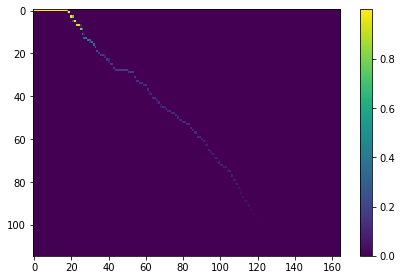

In [11]:
im = plt.imshow(np.exp(alphas), aspect='auto', interpolation='nearest')
plt.tight_layout()

plt.colorbar(im);

## Implement The CTC Backward Algorithm (4 points)

In [12]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    L = len(mod_sequence)
    T = matrix.shape[1]
    betas = np.full([L, T], NEG_INF)

    for t in reversed(range(T)):
        for s in reversed(range(L)):
            # First Step
            if t == matrix.shape[1] - 1:
                if s == L - 1:
                    betas[s, t] = 0
                elif s == L - 2:
                    betas[L - 2, t] = 0
                elif s < L - 2:
                    betas[s, t] = NEG_INF
            # Lower Diagonal Zeros
            elif s > 2 * t:
                betas[s, t] = NEG_INF
            else:
                if s == len(mod_sequence) - 1:
                    betas[s, t] = log_mult(betas[s, t + 1], matrix[mod_sequence[s], t])
                elif s == len(mod_sequence) - 2:
                    betas[s, t] = log_mult(logsumexp(betas[s, t + 1], betas[s + 1, t + 1]), matrix[mod_sequence[s], t])
                else:
                    if mod_sequence[s] == blank or mod_sequence[s] == mod_sequence[s + 2]:
                        betas[s, t] = log_mult(logsumexp(betas[s, t + 1], betas[s + 1, t + 1]), matrix[mod_sequence[s], t])
                    else:                
                        betas[s, t] = log_mult(logsumexp(betas[s, t + 1], betas[s + 1, t + 1], betas[s + 2, t + 1]), matrix[mod_sequence[s], t])
      
    return betas

In [13]:
# Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))

# Create label_sequence
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

betas = backward_algorithm(labels_indices, matrix)

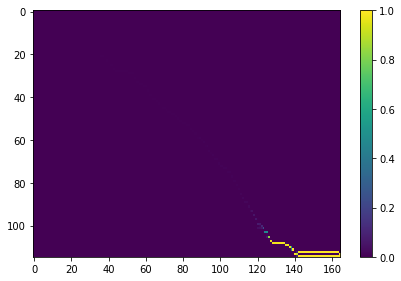

In [14]:
im = plt.imshow(np.exp(betas), aspect='auto', interpolation='nearest')
plt.tight_layout()

plt.colorbar(im);

## Obtain Soft-Alignment (2 points)


In [15]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas) * np.exp(betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0)

    return align

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


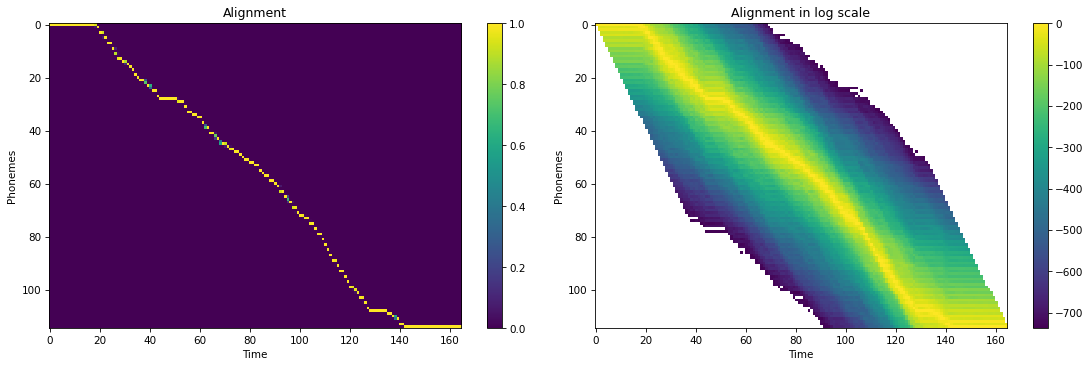

In [16]:
#!L
# Test your implementation

# Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))

# Create label_sequence
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indices, matrix)
f, ax = plt.subplots(1, 2, dpi=75, figsize=(15, 5))

im = ax[0].imshow(align, aspect='auto', interpolation='nearest')
ax[0].set_title("Alignment")
ax[0].set_ylabel("Phonemes")
ax[0].set_xlabel("Time")
f.colorbar(im, ax=ax[0])

im = ax[1].imshow(np.log(align), aspect='auto', interpolation='nearest')
ax[1].set_title("Alignment in log scale")
ax[1].set_ylabel("Phonemes")
ax[1].set_xlabel("Time")
f.colorbar(im, ax=ax[1])

plt.tight_layout()

ref_align = np.loadtxt(os.path.join(week_05_path, 'soft_alignment.txt'))
assert np.allclose(ref_align, align)

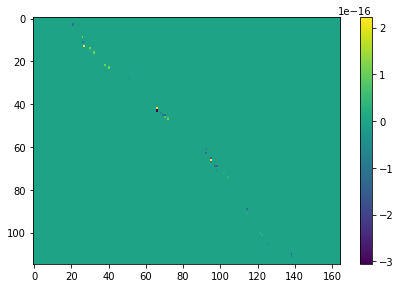

In [17]:
im = plt.imshow(ref_align - align, aspect='auto', interpolation='nearest')

plt.tight_layout()
plt.colorbar(im);

# Homework 2: CTC Speech Recognition System
You can do this notebook in google collab, or in datasphere (if you are brave enougth)

### Grades criteria

```
[ ] (2 points) Implement a Greedy Decoder
[ ] (8 points) Implement a Prefix Decoder
[ ] (20 points) Train ASR System, WER criterions: 60-50 -- 6 points, 50-40 -- 10 points, 40-35 -- 14 points, <=35 -- 20 points. + 1 bonus point per 1% WER below 30
[ ] (5 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
[ ] (5 points) Compare alignments obtained from DNN, RNN and BiRNN models
```

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells, training progress and final score.
2. file with predictions of your best model for the test data

Save the artifacts to a directory named `{your last name}_{your first name}_hw2` and pack them in `.zip` archive.


## Implementing a Decoder (10 points)

Before you can start having fun with a CTC ASR model, you first need to make sure that you can correctly "decode" or generate text from a working model. This can be done in two ways - using a Greedy Decoder, which is simple and fast, or using a Prefix Beam Search decoder, which is slower, but takes advantages of the fact that multiple plath though a CTC trellis can map to the sample sentence. In the following exercise you will implement both decoders.

### Implement a Greedy Best-Path Decoder! (2 points)

After we’ve trained the model, we’d like to use it to find a likely output for a given input. Your goal is to implement a Greedy Best-Path decoder. Remember than in CTC the joint distribution over states factors out into a product of marginals:

$${\tt P}(\mathbf{z}_{1:T}|\mathbf{X}_{1:T},\mathbf{\theta}) = \prod_{t = 1}^T{\tt P}(z_t|\mathbf{X}_{1:T},\mathbf{\theta})$$

We can take the most likely output at each time-step, which gives us the alignment with the highest probability:

$$\mathbf{\pi}^*_{1:T} = \arg \max_{\mathbf{\pi}_{1:T} } \prod_{t=1}^T {\tt P}(z_t = \pi_t|\mathbf{X}_{1:T})$$

Then merge repeats and remove blanks.

In [18]:
#!L
def greedy_decoder(output: torch.Tensor, labels: List[torch.Tensor], 
                   label_lengths: List[int], collapse_repeated: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: list of label indices converted to torch.Tensors
    :param label_lengths: list of label lengths (without padding)
    :param collapse_repeated: whether the repeated characters should be deduplicated
    :return: the result of the decoding and the target sequence
    """
    blank_label = tokenizer.get_symbol_index(BLANK_SYMBOL)

    # Get max classes
    ########################
    arg_maxes = torch.argmax(output, dim=2)
    ########################

    decodes = []
    targets = []

    # For targets and decodes remove repeats and blanks
    for i, args in enumerate(arg_maxes):
        decode = []
        true_labels = labels[i][:label_lengths[i]].tolist()
        targets.append(tokenizer.indices_to_text(true_labels))

        # Remove repeats, then remove blanks
        prev = blank_label
        for j, index in enumerate(args):
            if index != blank_label and prev != index:
                decode.append(index.item())
            
            prev = index
                
        decodes.append(tokenizer.indices_to_text(decode))
    return decodes, targets

In [19]:
#!L
# TESTING THE GREEDY DECODER

# Load numpy matrix, make its shape be in the form of [batch, classes, time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))[np.newaxis, :, :]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1, 2)

# Convert indices into torch.Tensor
labels_indices = torch.Tensor(tokenizer.text_to_indices('there seems no good reason for believing that it will change'))

# Run the Decoder
decodes, targets = greedy_decoder(matrix, [labels_indices], [len(labels_indices)])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

### Implement Prefix Decoding With LM (8 points)

The greedy decoder doesn't take into account the fact that a single output can have many alignments. For example, imagine that the true label for a phoneme sequence is $[a]$. Assume that alignments $[a, a, \epsilon]$ and $[a, a, a]$ individually have lower probability than the probability $[b, b, b]$, but the sum of their probabilities is higher. In this case, the greedy decoder would choose the wrong alignment $[b, b, b]$ and propose a wrong hypothesis $[b]$ instead of $[a]$.

Prefix decoding considers probabilities of multiple paths and merges them. It can also add external language model.

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1_X9NfoSe8HLKfAErDtr0rBsIxoejA1kq" height="500px" width="900px"> 

[(picture source)](https://distill.pub/2017/ctc/)

Prefix decoding algorithm has 3 nested loops:
- over time - we extend prefixes up to T times
- over prefixes in the beam
- over possible extensions of a prefix

Each prefix can be extended in three possible ways:
- with a blank
- with a repeating character
- with a non-repeating character

We must keep track of two probabilities per prefix:
- The probability of prefix ending with blank $P_b(t, s)$. 
- The probability of prefix not ending with blank $P_{nb}(t, s)$

Here $t$ denotes time step and $s$ denotes a prefix we got after $t$ time steps.

We start with an empty string prefix: 

$$
    P_b(0, \text{""}) = 1
$$
$$
    P_{nb}(0, \text{""}) = 0
$$

If we extend $s$ with a blank, update the probability of ending with a blank:

$$
    P_b(t, s) = P(\epsilon | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

The prefix $s$ is not updated because blanks are eliminated in the end.

If we extend with a repeat character $c$, there are two options:
1. The previous symbol is a blank, and now we extend the prefix
2. The previous symbol is not a blank, so we don't extend the prefix (repeats are merged)

In this case, the probability $P_{nb}$ is updated as follows:

$$
    P_{nb}(t, s + c) = P(c | x_t) \cdot P_b(t - 1, s)
$$
$$
    P_{nb}(t, s) = P(c | x_t) \cdot P_{nb}(t - 1, s)
$$

Finally, consider extending $s$ at time $t$ with a non-repeat character. It can follow both blank and non-blank characters, so the probability $P_{nb}$ is updated as follows:

$$
    P_{nb}(t, s + c) = P(c | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

We may also want to apply a language model during decoding, but only in the case we have a new complete word. This happens when the current symbol is a non-repeat space. As CTC is a discriminative model, LMs can only be integrated as a heuristic:

$$
    \mathbf{w}^* = \arg \max_\mathbf{w} \underbrace{P(\mathbf{w} | \mathbf{X}_{1:T})}_{\text{CTC prob}} \cdot \underbrace{P(\mathbf{w})^{\alpha}}_{\text{LM prob}} \cdot \underbrace{|\mathbf{w}|^\beta}_{\text{Length correction}}
$$

The formula for an update of $P_{nb}$ when LM is used and the current symbol is a non-repeat space:

$$
    P_{nb}(t, s + c) = P_{\text{LM}}(s)^\alpha \cdot |s|^\beta \cdot P(c | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

In [20]:
LanguageModel = TypeVar("LanguageModel")
# Helper function

class Beam:
    def __init__(self, beam_size: int) -> None:
        self.beam_size = beam_size
        
        fn = lambda : (NEG_INF, NEG_INF)
        self.candidates = defaultdict(fn)
        self.top_candidates_list = [(tuple(), (0.0, NEG_INF))]
        
    def get_probs_for_prefix(self, prefix: str) -> Tuple[float, float]:
        p_blank, p_not_blank = self.candidates[prefix]
        return p_blank, p_not_blank
        
    def update_probs_for_prefix(self, prefix: str, next_p_blank: float, next_p_not_blank: float) -> None:
        self.candidates[prefix] = (next_p_blank, next_p_not_blank)
        # if next_p_blank == NEG_INF and next_p_not_blank == NEG_INF:
        #     print(prefix)
        #     raise Exception
        
    def update_top_candidates_list(self) -> None:
        top_candidates = sorted(
            self.candidates.items(), 
            key=lambda x: logsumexp(*x[1]), 
            reverse=True
        )
        self.top_candidates_list = top_candidates[:self.beam_size]
        

def calculate_probability_score_with_lm(lm: LanguageModel, prefix: str) -> float:
    text = tokenizer.indices_to_text(prefix).upper().strip()    # Use upper case for LM and remove the trailing space
    lm_prob = lm.log_p(text)             
    score = lm_prob / np.log10(np.e)    # Convert to natural log, as ARPA LM uses log10   
    return score

In [21]:
#!L

def decode(probs: np.ndarray, beam_size: int = 5, lm: Optional[LanguageModel] = None, 
           prune: float = 1e-5, alpha: float = 0.1, beta: float = 2):
    """
    :param probs: A matrix of shape (T, K) with probability distributions over phonemes at each moment of time.
    :param beam_size: the size of beams
    :lm: arpa language model
    :prune: the minimal probability for a symbol at which it can be added to a prefix
    :alpha: the parameter to de-weight the LM probability
    :beta: the parameter to up-weight the length correction term
    :return: the prefix with the highest sum of probabilites P_blank and P_not_blank
    """
    T, S = probs.shape
    probs = np.log(probs)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    space = tokenizer.get_symbol_index(" ")
    prune = NEG_INF if prune == 0.0 else np.log(prune)
    
    beam = Beam(beam_size)

    for t in range(T):
        next_beam = Beam(beam_size)

        for s in range(S):
            p = probs[t, s]
            if p < prune: # Prune the vocab
                continue

            for prefix, (p_blank, p_not_blank) in beam.top_candidates_list:
                if s == blank:                    
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix = prefix,
                        next_p_blank = logsumexp(p_b, log_mult(p, logsumexp(p_blank, p_not_blank))),
                        next_p_not_blank = p_nb
                    )
                    continue

                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                
                if s == end_t:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix = n_prefix,
                        next_p_blank = p_b,
                        next_p_not_blank = logsumexp(p_nb, log_mult(p, p_blank)),
                    )
                    
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix = prefix,
                        next_p_blank = p_b,
                        next_p_not_blank = logsumexp(p_nb, log_mult(p, p_not_blank)),
                    )
                elif s == space and end_t is not None and lm is not None:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    score = calculate_probability_score_with_lm(lm, n_prefix)
                    length = len(tokenizer.indices_to_text(prefix))
                    
                    next_beam.update_probs_for_prefix(
                        prefix = n_prefix,
                        next_p_blank = p_b,
                        next_p_not_blank = logsumexp(p_nb, log_mult(score * alpha, np.log(len(prefix) ** beta), p, logsumexp(p_blank, p_not_blank))),
                    )
                else:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix = n_prefix,
                        next_p_blank = p_b,
                        next_p_not_blank = logsumexp(p_nb, log_mult(p, logsumexp(p_not_blank, p_blank))),
                    )

        next_beam.update_top_candidates_list()
        beam = next_beam

    best = beam.top_candidates_list[0]
    return best[0], -logsumexp(*best[1])


def beam_search_decoder(probs: np.ndarray, labels: List[List[int]], label_lengths: List[int], 
                        input_lengths: List[int], lm: LanguageModel, beam_size: int = 5,
                        prune: float = 1e-3, alpha: float = 0.1, beta: float = 0.1):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    
    for i, prob in enumerate(probs):
        targets.append(tokenizer.indices_to_text(labels[i][:label_lengths[i]].tolist()))
        int_seq, _ = decode(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, prune=prune, alpha=alpha, beta=beta)
        decodes.append(tokenizer.indices_to_text(int_seq))
        
    return decodes, targets

In [22]:
# Create LM
alm = arpa.loadf(os.path.join(week_05_path, '3-gram.pruned.1e-7.arpa'))[0]
alm._unk = '<UNK>'

In [23]:
#!L
# TESTING PREFIX Decoder

# Load numpy matrix, add axis [batch, classes, time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))[np.newaxis, :, :]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1, 2)

labels_indices = torch.Tensor(tokenizer.text_to_indices('there seems no good reason for believing that it will change'))

# Run the Decoder
decodes, targets = beam_search_decoder(
    matrix, [labels_indices], [len(labels_indices)], [matrix.size()[1]], 
    lm=None, beam_size=5, prune=1e-3, alpha=0.1, beta=0.3
)

print(decodes[0])

assert decodes[0] == 'there se ms no good reason for believing that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

decodes, targets = beam_search_decoder(
    matrix, [labels_indices], [len(labels_indices)], [matrix.size()[1]], 
    lm=alm, beam_size=5, prune=1e-3, alpha=0.1, beta=0.3
)

print(decodes[0])

assert decodes[0] == 'there seems no good reason for believing that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

there se ms no good reason for believing that twil c ange
there seems no good reason for believing that twil c ange


## Implementing, training and evaluationg your CTC ASR model

### Create a Dataloader

The first step is to create a dataloader to download and load and preprocess LibriSpeech acoustic data. 

The creative options you have at this stage are:

* The sample rate and number of mel-bins.
* Various forms of data agumentation

In [24]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [25]:
#!L
from torchaudio.transforms import Spectrogram, MelSpectrogram, AmplitudeToDB, MFCC
from torchaudio.transforms import FrequencyMasking, TimeMasking

# For train you can use SpecAugment data aug here.
train_audio_transforms = nn.Sequential(
    ################################################################################
    #Add features transformations here
    MelSpectrogram(sample_rate=16000, n_mels=128),
    # MFCC(sample_rate=16000),
    # Can add data augmentation here!
    FrequencyMasking(freq_mask_param=15),
    TimeMasking(time_mask_param=35),
    ################################################################################
)

test_audio_transforms = nn.Sequential(
    ################################################################################
    #Add feature transformations here
    MelSpectrogram(sample_rate=16000, n_mels=128),
    # MFCC(sample_rate=16000),
    ################################################################################
)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [26]:
class Collate:
  def __init__(self, data_type = 'test') -> None:
        super(Collate, self).__init__() 

        self.data_type = data_type

  def __call__(self, data: torchaudio.datasets.librispeech.LIBRISPEECH) -> Tuple[List[torch.Tensor], ...]:
        """
        :param data: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        spectrograms = []
        labels = []
        input_lengths = []
        label_lengths = []
        for (waveform, _, utterance, _, _, _) in data:
            if self.data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            elif self.data_type == 'test':
                spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                raise Exception('data_type should be train or valid')
            spectrograms.append(spec)
            label = torch.Tensor(tokenizer.text_to_indices(utterance.lower()))
            labels.append(label)
            input_lengths.append(spec.shape[0] // 2)
            label_lengths.append(len(label))

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

        return spectrograms, labels, input_lengths, label_lengths


### Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 6 points, 50-40 -- 10 points, 40-35 -- 14 points, <= 35 -- 20 points

In [27]:
#!L

# Our model classes are just examples, you can change them as you want

# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats: int) -> None:
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """

    def __init__(self, in_channels: int, out_channels: int, kernel: int, stride: int, dropout: float, n_feats: int) -> None:
        super(ResidualCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            *([
                CNNLayerNorm(n_feats),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=kernel // 2),
                CNNLayerNorm(n_feats),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=stride, padding=kernel // 2),
            ])
        )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x  # (batch, channel, feature, time)
        x = self.cnn(x)
        x += residual
        return x  # (batch, channel, feature, time)


class FeatureExtractor(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int,
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(FeatureExtractor, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3 // 2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[ResidualCNN(32, 32, kernel=3, 
                                                         stride=1, dropout=dropout, n_feats=n_feats) for _ in range(n_cnn_layers)])
        self.fully_connected = nn.Linear(32 * n_feats, rnn_dim)
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # [batchsize, features, max_length]
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        return x


class CTCDNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 1, dropout: float = 0.1) -> None:
        super(CTCDNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                 n_feats, stride, dropout)
        
        ########################
        self.intermediate_layers = [nn.Linear(rnn_dim, rnn_dim * 2), nn.GELU(), nn.Dropout(dropout)]
        self.intermediate_layers += [nn.Linear(rnn_dim * 2, rnn_dim * 2), nn.GELU(), nn.Dropout(dropout)] * (n_rnn_layers - 1)
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################

        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.intermediate_layers(x)
        x = self.classifier(x)
        return x

class GRUModule(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first, 
                 bidirectional=False):
        super(GRUModule, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=bidirectional)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

class CTCRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCRNN, self).__init__()

        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                        n_feats, stride, dropout)

        ########################
        self.intermediate_layers = [
            GRUModule(rnn_dim=rnn_dim,
                      hidden_size=rnn_dim, dropout=dropout, batch_first=True)
            for i in range(n_rnn_layers)
        ]
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################


        self.classifier = nn.Linear(rnn_dim, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.intermediate_layers(x)
        x = self.classifier(x)
        return x


class CTCBiRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCBiRNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                 n_feats, stride, dropout)

        ########################
        self.intermediate_layers = [
            GRUModule(rnn_dim=rnn_dim,
                      hidden_size=rnn_dim, dropout=dropout, batch_first=True, bidirectional=True)
            for i in range(n_rnn_layers)
        ]
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################


        self.classifier = nn.Linear(2 * rnn_dim, n_class)


    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.intermediate_layers(x)
        x = self.classifier(x)
        return x

### Training and Evaluation Code

In [28]:
#!L

def train(model: nn.Module, device: str, train_loader: data.DataLoader, 
          criterion: nn.Module, optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler, epoch: int) -> None:
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms, input_lengths)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))
            wandb.log({'loss_train': loss.item()})


def test(model: nn.Module, device: str, test_loader: data.DataLoader, 
         criterion: nn.Module, epoch: int, decode: str = 'Greedy', lm: LanguageModel = None, save_path: str = None) -> None:
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms, input_lengths)  # (batch, time, n_class)
            matrix = F.log_softmax(matrix, dim=2)
            probs = F.softmax(matrix,dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            if i == 3:
              np.savetxt(f"{save_path}_matrix.txt", probs[0].cpu().numpy())
              np.savetxt(f"{save_path}_labels.txt", labels[0].cpu().numpy())

            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = greedy_decoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                ## THIS IS THE FUNCTION YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = beam_search_decoder(probs, labels, label_lengths, input_lengths, lm=lm)
            for j in range(len(decoded_preds)):
                test_cer.append(utils.cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(utils.wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    wandb.log({'loss_test': test_loss, 'avg_cer': avg_cer, 'avg_wer': avg_wer})
    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))

In [29]:
#!L
#pragma async 
# PRAGMA ASYNC IS NECESSARY FOR TRAINING!
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

# Hyperparameters for your model
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 2,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 3e-4,
    "batch_size": 16,
    "epochs": 10
}

train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

GPU found! 🎉


We recommend to use "Weights & Biases" for experiment logging. See their [documentation](https://docs.wandb.ai/) for detais.

In [ ]:
wandb.init(project="speech-hw2", 
           group="DNN",
           config=hparams)

## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (5 points)

Train and discuss differences in the different models. 

Compare performance of DNN, RNN and BiRNN models in terms of:
-  WER / CER 
-  Training time
-  Training stability 
-  Any other properties?

In [35]:
# Train a non-recurrent model
ctc_dnn = CTCDNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
ctc_dnn.to(device)

criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
optimizer = optim.AdamW(ctc_dnn.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=hparams['learning_rate'],
                                          steps_per_epoch=int(len(train_loader)),
                                          epochs=hparams['epochs'],
                                          anneal_strategy='linear')

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_dnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn_epoch{epoch}.tar')
    wandb.save(f'ctc_dnn_epoch{epoch}.tar')
    test(ctc_dnn, device, test_loader, criterion, epoch, 'Greedy')

utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn.tar')

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 7.220731
Train Epoch: 1 [1600/28539 (6%)]	Loss: 3.165005
Train Epoch: 1 [3200/28539 (11%)]	Loss: 2.901189
Train Epoch: 1 [4800/28539 (17%)]	Loss: 2.919040
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.889415
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.878591
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.845693
Train Epoch: 1 [11200/28539 (39%)]	Loss: 2.846972
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.812337
Train Epoch: 1 [14400/28539 (50%)]	Loss: 2.766805
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.653426
Train Epoch: 1 [17600/28539 (62%)]	Loss: 2.558009
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.520375
Train Epoch: 1 [20800/28539 (73%)]	Loss: 2.400282
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.357821
Train Epoch: 1 [24000/28539 (84%)]	Loss: 2.336493
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.320795
Train Epoch: 1 [27200/28539 (95%)]	Loss: 2.302408
Beginning eval...
Epoch: 1, Test set: Average loss: 2.1474, Average CER: 0.628791 Average WER: 1.0506

Train Epo

In [30]:
wandb.init(project="speech-hw2", 
           group="RNN",
           config=hparams)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Train a  recurrent model
ctc_rnn = CTCRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
optimizer = optim.AdamW(ctc_rnn.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=hparams['learning_rate'],
                                          steps_per_epoch=int(len(train_loader)),
                                          epochs=hparams['epochs'],
                                          anneal_strategy='linear')

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_rnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn_epoch{epoch}.tar')
    wandb.save(f'ctc_rnn_epoch{epoch}.tar')
    test(ctc_rnn, device, test_loader, criterion, epoch, 'Greedy')

utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn.tar')

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 7.276604
Train Epoch: 1 [1600/28539 (6%)]	Loss: 2.957667
Train Epoch: 1 [3200/28539 (11%)]	Loss: 2.891584
Train Epoch: 1 [4800/28539 (17%)]	Loss: 2.855871
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.859533
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.873445
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.840994
Train Epoch: 1 [11200/28539 (39%)]	Loss: 2.828822
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.754033
Train Epoch: 1 [14400/28539 (50%)]	Loss: 2.609796
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.484655
Train Epoch: 1 [17600/28539 (62%)]	Loss: 2.334424
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.223828
Train Epoch: 1 [20800/28539 (73%)]	Loss: 2.197560
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.115492
Train Epoch: 1 [24000/28539 (84%)]	Loss: 2.205276
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.025156
Train Epoch: 1 [27200/28539 (95%)]	Loss: 1.958459
Beginning eval...
Epoch: 1, Test set: Average loss: 1.8287, Average CER: 0.537373 Average WER: 1.0331

Train Epo

In [ ]:
wandb.init(project="speech-hw2", 
           group="BiRNN",
           config=hparams)

In [ ]:
# Train a  recurrent model
ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = # YOUR CODE  - SUGGESTED ADAM
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = # YOUR CODE  - SUGGESTED ONE CYCLE

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
    wandb.save(f'ctc_birnn_epoch{epoch}.tar')
    test(ctc_birnn, device, test_loader, criterion, epoch, 'birnn')

utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn.tar')

Results: https://wandb.ai/grazder/speech-hw2

## Compare alignments (5 points)

In this section you should compare alignments obtained from different models (DNN / RNN / BiRNN). For example, you can show:

- Examples of alignments and their analysis. 
- Differencies in the properties of alignment distributions over the dataset. 
- Dynamic of alignments during training (from checkpoints). 
- Connection between alignments and model loss. 
- Which models use the most blanks and why?

In [ ]:
# Some code to get you started.
dnn_matrix = np.loadtxt('dnn_matrix.txt')
rnn_matrix = np.loadtxt('rnn_matrix.txt')
birnn_matrix = np.loadtxt('birnn_matrix.txt')

dnn_labels = np.loadtxt('dnn_labels.txt', dtype=np.int32)
rnn_labels = np.loadtxt('rnn_labels.txt', dtype=np.int32)
birnn_labels = np.loadtxt('birnn_labels.txt', dtype=np.int32)

dnn_align = soft_alignment(dnn_labels, dnn_matrix)
rnn_align = soft_alignment(rnn_labels, rnn_matrix)
birnn_align = soft_alignment(birnn_labels, birnn_matrix)

f, ax = plt.subplots(3, 2, dpi=75, figsize=(15, 15))


im = ax[0,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[0,0].set_title("DNN Alignment")
ax[0,0].set_ylabel("Phonemes")
ax[0,0].set_xlabel("Time")
f.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[0,1].set_title("DNN Alignment in log scale")
ax[0,1].set_ylabel("Phonemes")
ax[0,1].set_xlabel("Time")
f.colorbar(im, ax=ax[0,1])

im = ax[1,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[1,0].set_title("RNN Alignment")
ax[1,0].set_ylabel("Phonemes")
ax[1,0].set_xlabel("Time")
f.colorbar(im, ax=ax[1,0])

im = ax[1,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[1,1].set_title("RNN Alignment in log scale")
ax[1,1].set_ylabel("Phonemes")
ax[1,1].set_xlabel("Time")
f.colorbar(im, ax=ax[1,1])

im = ax[2,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[2,0].set_title("BiRNN Alignment")
ax[2,0].set_ylabel("Phonemes")
ax[2,0].set_xlabel("Time")
f.colorbar(im, ax=ax[2,0])

im = ax[2,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[2,1].set_title("BiRNN Alignment in log scale")
ax[2,1].set_ylabel("Phonemes")
ax[2,1].set_xlabel("Time")
f.colorbar(im, ax=ax[2,1])

plt.tight_layout()